# Práctica de descarga de Sentinel-2: Microsoft Planetary Computer

En este cuaderno se realiza paso a paso el siguiente proceso:

> Nota: Los datasets públicos de Planetary Computer permiten obtener un **token SAS sin necesidad de una clave API**, lo que facilita la descarga de los datos.

In [1]:
# !pip install -U -q geopandas shapely pyproj rasterio rioxarray xarray
# !pip install -U -q pystac-client planetary-computer
# !pip install -U -q leafmap

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import planetary_computer
import requests
import rasterio
import rioxarray
import xarray as xr
import numpy as np

from shapely.geometry import box, shape
from datetime import datetime
from pystac_client import Client
from rasterio.io import MemoryFile
from rasterio.enums import Resampling
from rasterio.transform import Affine

import warnings
warnings.filterwarnings("ignore")

### Carga y visualización de los límites del parque nacional

Se carga el archivo GPKG con los límites del parque nacional, se verifica su sistema de coordenadas y se visualizan los contornos en forma de mapa.

Original CRS: EPSG:4326


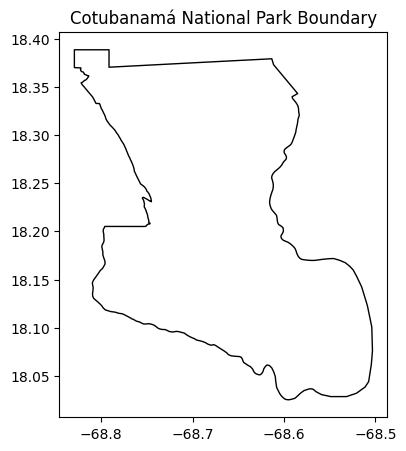

In [2]:
url = "https://raw.githubusercontent.com/osgeokr/mmarn-data-capacity-2025/main/cotubanama_np_boundary.gpkg"

gdf = gpd.read_file(url)
print("Original CRS:", gdf.crs)

ax = gdf.plot(edgecolor="black", facecolor="none", figsize=(5, 5))
ax.set_title("Cotubanamá National Park Boundary")
plt.show()

### Estimación del sistema de coordenadas UTM

A partir de la distribución espacial de los datos del límite, se estima el sistema de coordenadas UTM más adecuado y se verifica su validez.

In [3]:
# Estimar y verificar el CRS UTM
utm_crs = gdf.estimate_utm_crs()
print("Estimated UTM CRS:", utm_crs)

Estimated UTM CRS: EPSG:32619


### Creación de un buffer y construcción de la caja envolvente (Bounding Box)

Después de transformar los datos del límite al sistema de coordenadas UTM, se genera un buffer de 10 km.  
El buffer obtenido se convierte nuevamente a WGS84 y, con base en él, se calcula la caja envolvente (Bounding Box), que luego se construye como un GeoDataFrame.  
Finalmente, se visualizan en conjunto el límite original, el buffer y la Bounding Box para verificar el alcance espacial.

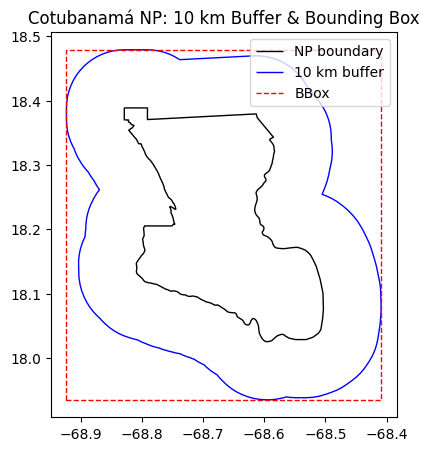

In [4]:
# Convertir a UTM
gdf_utm = gdf.to_crs(utm_crs)

# Crear un buffer de 10 km (10,000 m)
buffer_utm = gdf_utm.buffer(10_000)

# Convertir nuevamente a WGS84
buffer_gdf = gpd.GeoDataFrame(geometry=buffer_utm, crs=utm_crs).to_crs(gdf.crs)

# Crear la Bounding Box del buffer
minx, miny, maxx, maxy = buffer_gdf.total_bounds
bbox_geom = box(minx, miny, maxx, maxy)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox_geom], crs=gdf.crs)

# Visualización
fig, ax = plt.subplots(figsize=(5, 5))
gdf.boundary.plot(ax=ax, color="black", linewidth=1, label="NP boundary")
buffer_gdf.boundary.plot(ax=ax, color="blue", linewidth=1, label="10 km buffer")
bbox_gdf.boundary.plot(ax=ax, color="red", linestyle="--", linewidth=1, label="BBox")

ax.set_title("Cotubanamá NP: 10 km Buffer & Bounding Box")
ax.legend()
plt.show()

### Búsqueda STAC de Sentinel-2

Se utiliza la API STAC de Planetary Computer para buscar imágenes Sentinel-2 L2A que cumplan con los siguientes criterios:  
punto central del Bounding Box, intervalo de fechas y umbral de cobertura de nubes.  
De los resultados obtenidos, se selecciona la escena con **menor cobertura de nubes** y **fecha más reciente o más temprana**, según el criterio definido.

In [5]:
def search_sentinel2_planet_computer(bbox_gdf, time_range, max_cloud=20):
    """
    Buscar imágenes Sentinel-2 L2A desde Planetary Computer usando:
    - Bounding Box (centro del área)
    - Rango temporal
    - Límite máximo de nubosidad
    Retorna el ítem con menor nubosidad y fecha más temprana.
    """

    # Calcular el punto central del Bounding Box
    center = bbox_gdf.geometry.union_all().centroid
    center_geojson = center.__geo_interface__

    # Conectar al catálogo STAC de Planetary Computer
    catalog = Client.open(
        "https://planetarycomputer.microsoft.com/api/stac/v1",
        modifier=planetary_computer.sign_inplace,
    )

    # Realizar la búsqueda STAC
    search = catalog.search(
        collections=["sentinel-2-l2a"],
        intersects=center_geojson,
        datetime=time_range,
        query={"eo:cloud_cover": {"lt": max_cloud}},
    )
    
    items = list(search.items())
    if not items:
        print(f"[INFO] No se encontraron imágenes Sentinel-2 que cumplan las condiciones. "
              f"(Nubosidad < {max_cloud}%, Período = {time_range})")
        return None
    
    # Ordenar por: 1) menor nubosidad, 2) fecha más temprana
    def sort_key(item):
        cloud = item.properties.get("eo:cloud_cover", 100)
        dt = item.datetime or datetime.max
        return (cloud, dt)

    return sorted(items, key=sort_key)[0]

### Visualización de la imagen de vista previa de Sentinel-2

A partir del ítem STAC se busca el recurso `rendered_preview` o `thumbnail`, se descarga de forma remota y se carga en memoria para convertirlo en una imagen RGB mostrable en pantalla.  
En el título de la figura se muestran también el ID de la escena, la fecha de adquisición y el porcentaje de nubosidad.

In [6]:
def show_sentinel2_preview(item):
    if item is None:
        print("[WARN] el objeto 'item' es None. Verifique los resultados de la búsqueda.")
        return

    # Seleccionar el recurso de vista previa
    if "rendered_preview" in item.assets:
        asset = item.assets["rendered_preview"]
    elif "thumbnail" in item.assets:
        asset = item.assets["thumbnail"]
    else:
        raise ValueError("No se encontró un recurso de vista previa.")

    # Descargar imagen remota
    r = requests.get(asset.href)
    r.raise_for_status()

    # Leer en memoria usando rasterio
    with MemoryFile(r.content) as memfile:
        with memfile.open() as src:
            img = src.read()  # (3, H, W)
            img_plot = img.transpose((1, 2, 0))  # RGB

    # Renderizar
    plt.figure(figsize=(6, 6))
    plt.imshow(img_plot)
    plt.axis("off")
    plt.title(
        f"{item.id}\n"
        f"{item.datetime.date()} | Nubes: {item.properties.get('eo:cloud_cover', 'NA')}%"
    )
    plt.show()

### Búsqueda de escenas Sentinel-2 y vista previa

Se buscan escenas Sentinel-2 según el período de tiempo y el umbral de nubosidad especificados, y se muestra en pantalla la imagen de vista previa de la escena seleccionada.

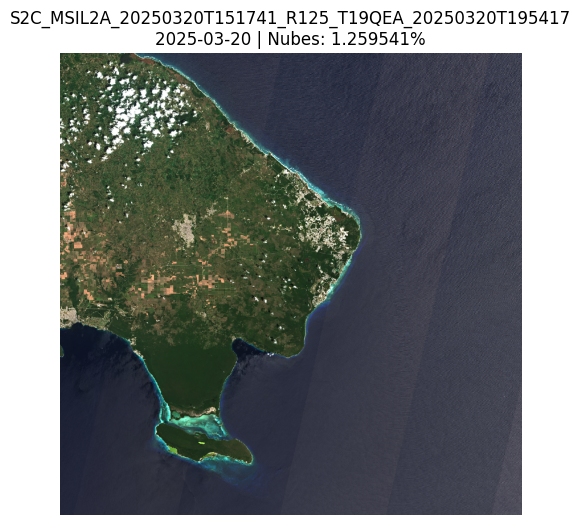

In [7]:
time_range = "2025-01-01/2025-10-31"
item = search_sentinel2_planet_computer(bbox_gdf, time_range, max_cloud=10)
show_sentinel2_preview(item)

### Visualización comparativa del área de la escena Sentinel-2 y el área de análisis

Se convierte la extensión espacial de la escena Sentinel-2 seleccionada a un GeoDataFrame y se representa en un mapa junto con la Bounding Box y los límites del parque nacional, para comprobar la relación espacial entre ellos.

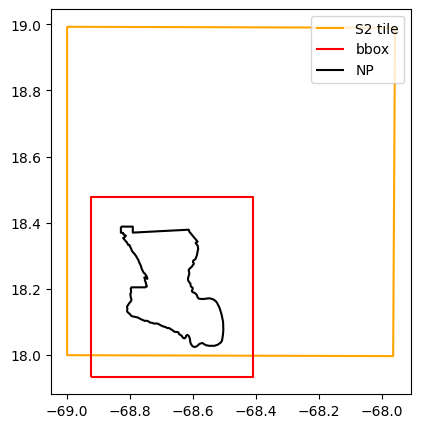

In [8]:
s2_geom = shape(item.geometry)
s2_gdf = gpd.GeoDataFrame(geometry=[s2_geom], crs="EPSG:4326")

ax = s2_gdf.boundary.plot(color="orange", figsize=(5, 5), label="S2 tile")
bbox_gdf.boundary.plot(ax=ax, color="red", label="bbox")
gdf.boundary.plot(ax=ax, color="black", label="NP")
ax.legend()
plt.show()

### Descarga y recorte de bandas Sentinel-2

A partir del STAC Item seleccionado, se descargan secuencialmente las bandas especificadas y se recortan utilizando la Bounding Box definida para el análisis.  
Cada banda recortada se guarda como un archivo GeoTIFF y, posteriormente, todas las bandas se combinan en memoria en un solo *stack* para su uso en el flujo de análisis.

In [9]:
def download_sentinel2_bands(item, bands, bbox_gdf, out_tif):
    """
    Descarga y recorta bandas Sentinel-2 a partir de un STAC Item.

    Parámetros
    ----------
    item : STAC item
        Objeto STAC que contiene los recursos de Sentinel-2.
    bands : list of str
        Lista de bandas a descargar, por ejemplo ["B02", "B03", "B04"].
    bbox_gdf : GeoDataFrame
        Bounding Box en EPSG:4326 que define el área de análisis.
    out_tif : str
        Prefijo para los archivos GeoTIFF de salida.
    """
    das = []

    for b in bands:
        print(f"[INFO] Descargando y recortando {b}...")

        href = item.assets[b].href
        da = rioxarray.open_rasterio(href, masked=True).squeeze()

        # Convertir la Bounding Box al CRS del ráster
        bbox_proj = bbox_gdf.to_crs(da.rio.crs)
        minx, miny, maxx, maxy = bbox_proj.total_bounds

        da_clip = da.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)
        da_clip.name = b
        das.append(da_clip)

        # Nombre del archivo para cada banda (prefijo + nombre de banda)
        out_file = f"{out_tif}{b.lower()}.tif"

        # Guardar como GeoTIFF
        da_clip.rio.to_raster(out_file)

        # Asignar nombre de banda con rasterio
        with rasterio.open(out_file, "r+") as dst:
            dst.set_band_description(1, b)

        print(f"[INFO] Archivo guardado: {out_file}")

    # Crear un stack en memoria con todas las bandas
    stack = xr.concat(das, dim="band")
    stack = stack.assign_coords(band=bands)

    print("[INFO] Descarga y guardado de todas las bandas completados")

    return stack

In [15]:
bands = ["B02", "B03", "B04"]
stack = download_sentinel2_bands(item, bands, bbox_gdf, "sentinel2_")

[INFO] Descargando y recortando B05...
[INFO] Archivo guardado: sentinel2_b05.tif
[INFO] Descargando y recortando B08...
[INFO] Archivo guardado: sentinel2_b08.tif
[INFO] Descargando y recortando B11...
[INFO] Archivo guardado: sentinel2_b11.tif
[INFO] Descarga y guardado de todas las bandas completados


### Guardar el *stack* de bandas como un único GeoTIFF

A partir del *stack* de bandas construido en memoria, se definen los metadatos del GeoTIFF y se escriben cada una de las bandas con el nombre correspondiente, para generar un único archivo GeoTIFF multibanda.

In [11]:
def save_stack_as_tif(stack, bands, out_file):
    """
    stack: xr.DataArray (shape: [band, y, x])
    bands: ["B02","B03","B04"] lista de nombres de bandas
    out_file: nombre del archivo TIFF de salida (ej: "sentinel-2_rgb.tif")
    """

    # Obtener metadatos
    height, width = stack.shape[1], stack.shape[2]
    transform = stack.rio.transform()
    crs = stack.rio.crs

    # Crear perfil de rasterio
    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": len(bands),
        "dtype": stack.dtype,
        "crs": crs,
        "transform": transform,
    }

    # Guardar archivo
    with rasterio.open(out_file, "w", **profile) as dst:
        for i, b in enumerate(bands, start=1):
            dst.write(stack.sel(band=b).values, i)
            dst.set_band_description(i, b)

    print(f"[INFO] Archivo de *stack* guardado: {out_file}")

In [12]:
bands = ["B02", "B03", "B04"]
save_stack_as_tif(stack, bands, "sentinel2_rgb.tif")

[INFO] Archivo de *stack* guardado: sentinel2_rgb.tif


### Visualización del GeoTIFF guardado aplicando *stretch*

A partir del GeoTIFF se extraen las bandas seleccionadas por nombre y se aplica un *stretch* de percentiles 2–98% a cada una de ellas, para visualizar la imagen tanto en modo de banda única como en composición multibanda.

In [13]:
def show_tif(tif_path, band_names):
    """
    Visualiza bandas seleccionadas de un GeoTIFF aplicando un stretch del 2–98%.

    Parámetros
    ----------
    tif_path : str
        Ruta del archivo GeoTIFF.
    band_names : list
        Lista con los nombres de las bandas que se desean visualizar.
        Ejemplo: ["B04", "B03", "B02"] para RGB.
    """

    with rasterio.open(tif_path) as src:
        img = src.read()                      # (bands, H, W)
        desc = list(src.descriptions)         # Nombres de bandas almacenadas

    # Mapeo de nombre de banda → índice
    band_indices = []
    for name in band_names:
        if name not in desc:
            raise ValueError(f"No se encontró la banda '{name}' en el GeoTIFF.")
        band_indices.append(desc.index(name))

    selected = img[band_indices, :, :]

    # Stretch 2–98 %
    def stretch(arr):
        p2 = np.percentile(arr, 2)
        p98 = np.percentile(arr, 98)
        arr_clip = np.clip(arr, p2, p98)
        return (arr_clip - p2) / (p98 - p2 + 1e-6)

    # Visualización de banda única
    if selected.shape[0] == 1:
        stretched = stretch(selected[0])
        plt.figure(figsize=(7,7))
        plt.imshow(stretched, cmap='gray')
        plt.axis("off")
        plt.title(f"{tif_path}\nBanda: {band_names[0]}")
        plt.show()

    # Visualización multibanda (RGB, etc.)
    else:
        stretched_bands = [stretch(selected[i]) for i in range(selected.shape[0])]
        rgb = np.stack(stretched_bands, axis=-1)
        plt.figure(figsize=(6,6))
        plt.imshow(rgb)
        plt.axis("off")
        plt.title(f"{tif_path}\nBandas: {band_names}")
        plt.show()

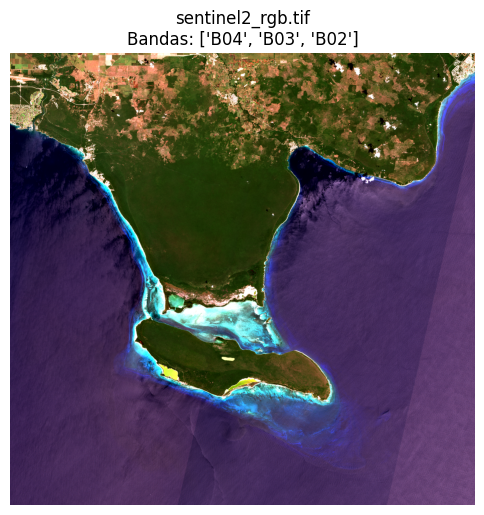

In [14]:
show_tif("sentinel2_rgb.tif", ["B04", "B03", "B02"])